In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

In [2]:
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--test-batch-size', type=int, default=128, metavar='N',
                    help='input batch size for testing (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-accel', action='store_true', 
                    help='disables accelerator')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--latent-dim', type=int, default=2, metavar='N',
                    help='dimensionality of the latent space (default: 2)')
args, _ = parser.parse_known_args()

In [3]:
use_accel = not args.no_accel and torch.accelerator.is_available()

torch.manual_seed(args.seed)


if use_accel:
    device = torch.accelerator.current_accelerator()
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_accel else {'num_workers': 0}

Using device: mps


In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       lambda x: x>0,
                       lambda x: x.float(),
            ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       lambda x: x>0,
                       lambda x: x.float(),
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, args.latent_dim)
        self.fc22 = nn.Linear(400, args.latent_dim)
        self.fc3 = nn.Linear(args.latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [7]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                os.makedirs('results', exist_ok=True)
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:
for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, args.latent_dim).to(device)
        sample = model.decode(sample).cpu()
        print(sample.shape)
        os.makedirs('results', exist_ok=True)
        save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')

/Users/arn/Downloads/PML/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Epoch: 1 [0/60000 (0%)]	Loss: 550.521118
Train Epoch: 1 [1280/60000 (2%)]	Loss: 275.157501
Train Epoch: 1 [2560/60000 (4%)]	Loss: 249.936020
Train Epoch: 1 [3840/60000 (6%)]	Loss: 231.947571
Train Epoch: 1 [2560/60000 (4%)]	Loss: 249.936020
Train Epoch: 1 [3840/60000 (6%)]	Loss: 231.947571
Train Epoch: 1 [5120/60000 (9%)]	Loss: 224.422729
Train Epoch: 1 [6400/60000 (11%)]	Loss: 226.951370
Train Epoch: 1 [5120/60000 (9%)]	Loss: 224.422729
Train Epoch: 1 [6400/60000 (11%)]	Loss: 226.951370
Train Epoch: 1 [7680/60000 (13%)]	Loss: 217.293701
Train Epoch: 1 [8960/60000 (15%)]	Loss: 208.200516
Train Epoch: 1 [7680/60000 (13%)]	Loss: 217.293701
Train Epoch: 1 [8960/60000 (15%)]	Loss: 208.200516
Train Epoch: 1 [10240/60000 (17%)]	Loss: 210.572327
Train Epoch: 1 [11520/60000 (19%)]	Loss: 212.391083
Train Epoch: 1 [10240/60000 (17%)]	Loss: 210.572327
Train Epoch: 1 [11520/60000 (19%)]	Loss: 212.391083
Train Epoch: 1 [12800/60000 (21%)]	Loss: 201.631561
Train Epoch: 1 [14080/60000 (23%)]	Lo

In [9]:
model.eval()

mu_latent_list = []
labels_latent_list = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        mu, _ = model.encode(data.view(-1, 784))
        mu_latent_list.append(mu.cpu())
        labels_latent_list.append(labels.cpu())

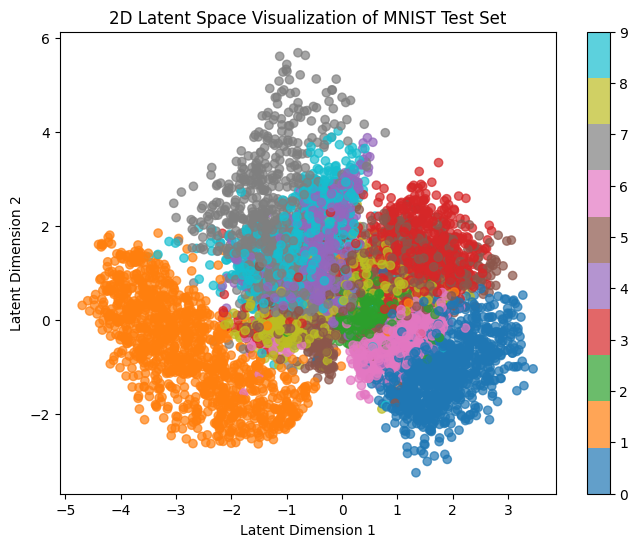

In [10]:
import matplotlib.pyplot as plt
import numpy as np

mu_latent = torch.cat(mu_latent_list).numpy()
labels_latent = torch.cat(labels_latent_list).numpy()
plt.figure(figsize=(8, 6))
scatter = plt.scatter(mu_latent[:, 0], mu_latent[:, 1], c=labels_latent, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization of MNIST Test Set')
plt.show()

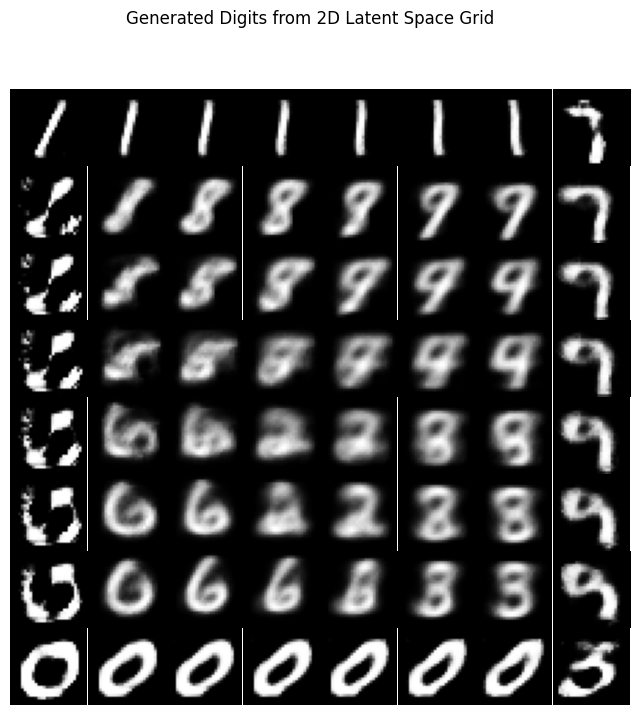

In [17]:
k = 8
epsilon = 1e-6

grid = torch.linspace(0 + epsilon, 1 - epsilon, k)
grid_x, grid_y = torch.meshgrid(grid, grid)

# torch.distributions.normal.Normal.icdf
grid_x = torch.distributions.normal.Normal(0, 1).icdf(grid_x)
grid_y = torch.distributions.normal.Normal(0, 1).icdf(grid_y)

with torch.no_grad():
    sample = torch.zeros((k * k, args.latent_dim))
    sample[:, 0] = grid_x.reshape(-1)
    sample[:, 1] = grid_y.reshape(-1)
    sample = sample.to(device)

    reconstructions = model.decode(sample).view(k * k, 1, 28, 28).cpu()


plt.figure(figsize=(8, 8))
for i in range(k * k):
    plt.subplot(k, k, i + 1)
    plt.imshow(reconstructions[i, 0], cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('Generated Digits from 2D Latent Space Grid')
plt.show()